In [2]:
%load_ext autoreload
%autoreload 2

## Libraries

In [3]:
# Librerías estándar
import math

# Librerías de terceros: manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para Matplotlib
plt.rcParams['figure.figsize'] = [25, 8]

# Librerías de terceros: machine learning y métricas
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Librerías de terceros: series de tiempo y clustering
from tslearn.clustering import silhouette_score, TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Importaciones específicas del proyecto
from lightweight_clustered_energy_forecasts.utils.paths import data_dir


c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Funciones auxiliares

In [4]:
def nan_counter(list_of_dataframes):
    nan_polluted_series_counter = 0
    for dataframe in list_of_dataframes:
        if dataframe.isna().any().any():  # Verifica si hay NaN en cualquier columna
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)


## Procesing data

In [5]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [6]:
building_11a=building_11a.resample("h").sum()

In [7]:
#realizamos una lista de arrays cada array correspondiendo a 1 dia de datos con frecuencia de muestreo por 15 minutos
# Agrupar por día
df=building_11a.copy()
# Agrupar por día y guardar los DataFrames en una lista
list_of_dataframes = [group for _, group in df.groupby(df.index.date)]

# Imprimir el resultado
for i, daily_df in enumerate(list_of_dataframes):
    print(f"Día {i+1}:")
    print(daily_df)
    print("-" * 50)


Día 1:
                             kwh
timestamp                       
2023-01-01 00:00:00+00:00  54.90
2023-01-01 01:00:00+00:00  53.81
2023-01-01 02:00:00+00:00  52.92
2023-01-01 03:00:00+00:00  55.99
2023-01-01 04:00:00+00:00  57.55
2023-01-01 05:00:00+00:00  53.89
2023-01-01 06:00:00+00:00  52.87
2023-01-01 07:00:00+00:00  46.73
2023-01-01 08:00:00+00:00  51.08
2023-01-01 09:00:00+00:00  55.15
2023-01-01 10:00:00+00:00  51.41
2023-01-01 11:00:00+00:00  57.62
2023-01-01 12:00:00+00:00  56.59
2023-01-01 13:00:00+00:00  59.29
2023-01-01 14:00:00+00:00  61.22
2023-01-01 15:00:00+00:00  60.16
2023-01-01 16:00:00+00:00  57.73
2023-01-01 17:00:00+00:00  59.19
2023-01-01 18:00:00+00:00  61.27
2023-01-01 19:00:00+00:00  65.10
2023-01-01 20:00:00+00:00  57.67
2023-01-01 21:00:00+00:00  58.05
2023-01-01 22:00:00+00:00  59.79
2023-01-01 23:00:00+00:00  60.30
--------------------------------------------------
Día 2:
                             kwh
timestamp                       
2023-01-02 

In [8]:
nan_counter(list_of_dataframes)

0


In [9]:
len(list_of_dataframes)

365

<Axes: xlabel='timestamp'>

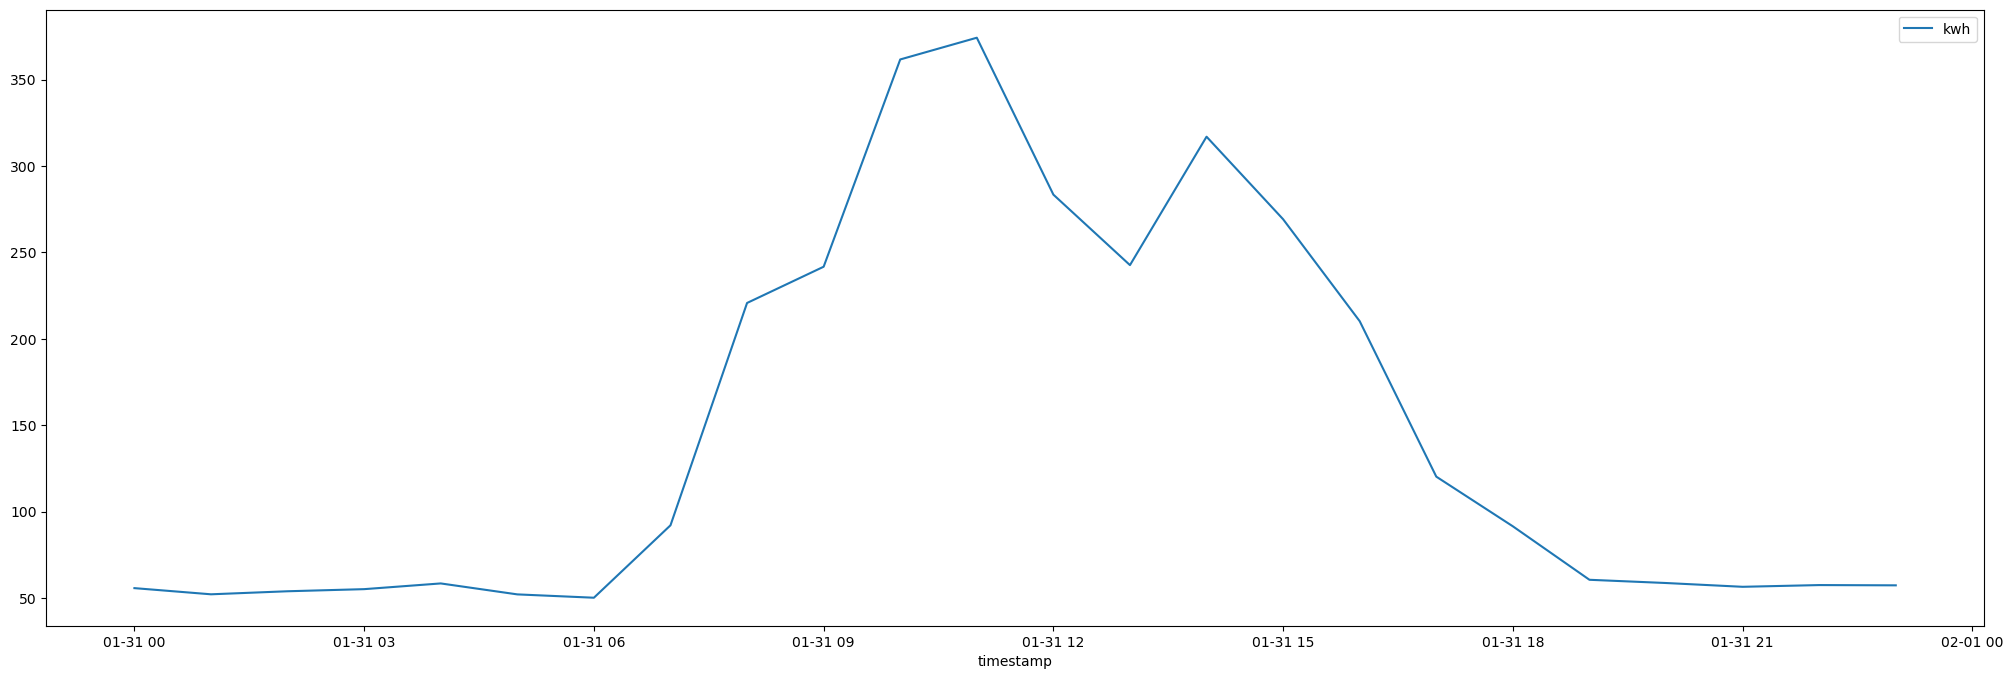

In [10]:
sns.lineplot(list_of_dataframes[30])

## clustering

Después de gestionar los valores faltantes, el otro problema es la escala de la serie. Sin la normalización de los datos, las series que se parecen entre sí se verán muy diferentes entre sí y afectarán la precisión del proceso de agrupamiento. Podemos ver el efecto de la normalización en las siguientes imágenes.

In [11]:
normalized_list_of_dataframes = []

for daily_df in list_of_dataframes:
    scaler = MinMaxScaler()
    # Normalizar cada día por separado
    normalized_daily_df = scaler.fit_transform(daily_df.values.reshape(-1, 1))  # Reshape para ajustarse a la entrada del scaler
    normalized_list_of_dataframes.append(normalized_daily_df.flatten())  # Volver a la forma 1D


El resultado del proceso de normalización parece bueno.

In [12]:
print("max: "+str(max(normalized_list_of_dataframes[0]))+"\tmin: "+str(min(normalized_list_of_dataframes[0])))
print(normalized_list_of_dataframes[0][:5])

max: 1.0	min: 0.0
[0.44474687 0.385411   0.33696244 0.50408274 0.58900381]


## kmeans

In [13]:
# Definir el rango de k para probar
K = range(2, 8)
Sum_of_squared_distances = []
Silhouette_Scores = []

# Probar con diferentes valores de k
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",  # Usamos DTW como métrica de distancia
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    # Ajustar el modelo a los datos
    km = km.fit(normalized_list_of_dataframes)
    
    # Almacenar la inercia para este valor de k
    Sum_of_squared_distances.append(km.inertia_)
    silhouette = silhouette_score(normalized_list_of_dataframes, km.labels_)
    Silhouette_Scores.append(silhouette)

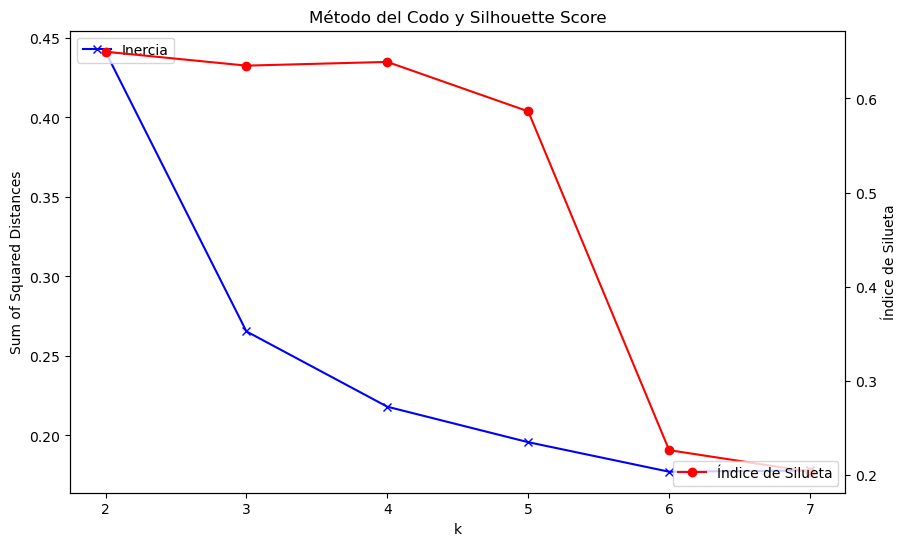

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico del codo (inercia)
ax1.plot(K, Sum_of_squared_distances, 'bx-', label="Inercia")
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of Squared Distances')
ax1.set_title('Método del Codo y Silhouette Score')

# Crear un segundo eje y para el índice de silueta
ax2 = ax1.twinx()
ax2.plot(K, Silhouette_Scores, 'ro-', label="Índice de Silueta")
ax2.set_ylabel('Índice de Silueta')

# Mostrar la leyenda
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

In [15]:
Sum_of_squared_distances

[np.float64(0.44130106822624143),
 np.float64(0.2654060092499969),
 np.float64(0.21803211406482984),
 np.float64(0.19572773501533122),
 np.float64(0.17714936074504653),
 np.float64(0.17794310812958056)]

## Training  kmeans 

usando distancia Euclidiana

In [16]:
# Aplicar el clustering con el número óptimo de clusters
optimal_k = 4
km = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", verbose=False)

# Ajustar el modelo y predecir las etiquetas de los clusters
labels = km.fit_predict(normalized_list_of_dataframes)

# Mostrar las primeras etiquetas de los clusters
print("Etiquetas de los clusters para las primeras series:", labels[:5])


Etiquetas de los clusters para las primeras series: [2 3 1 1 1]


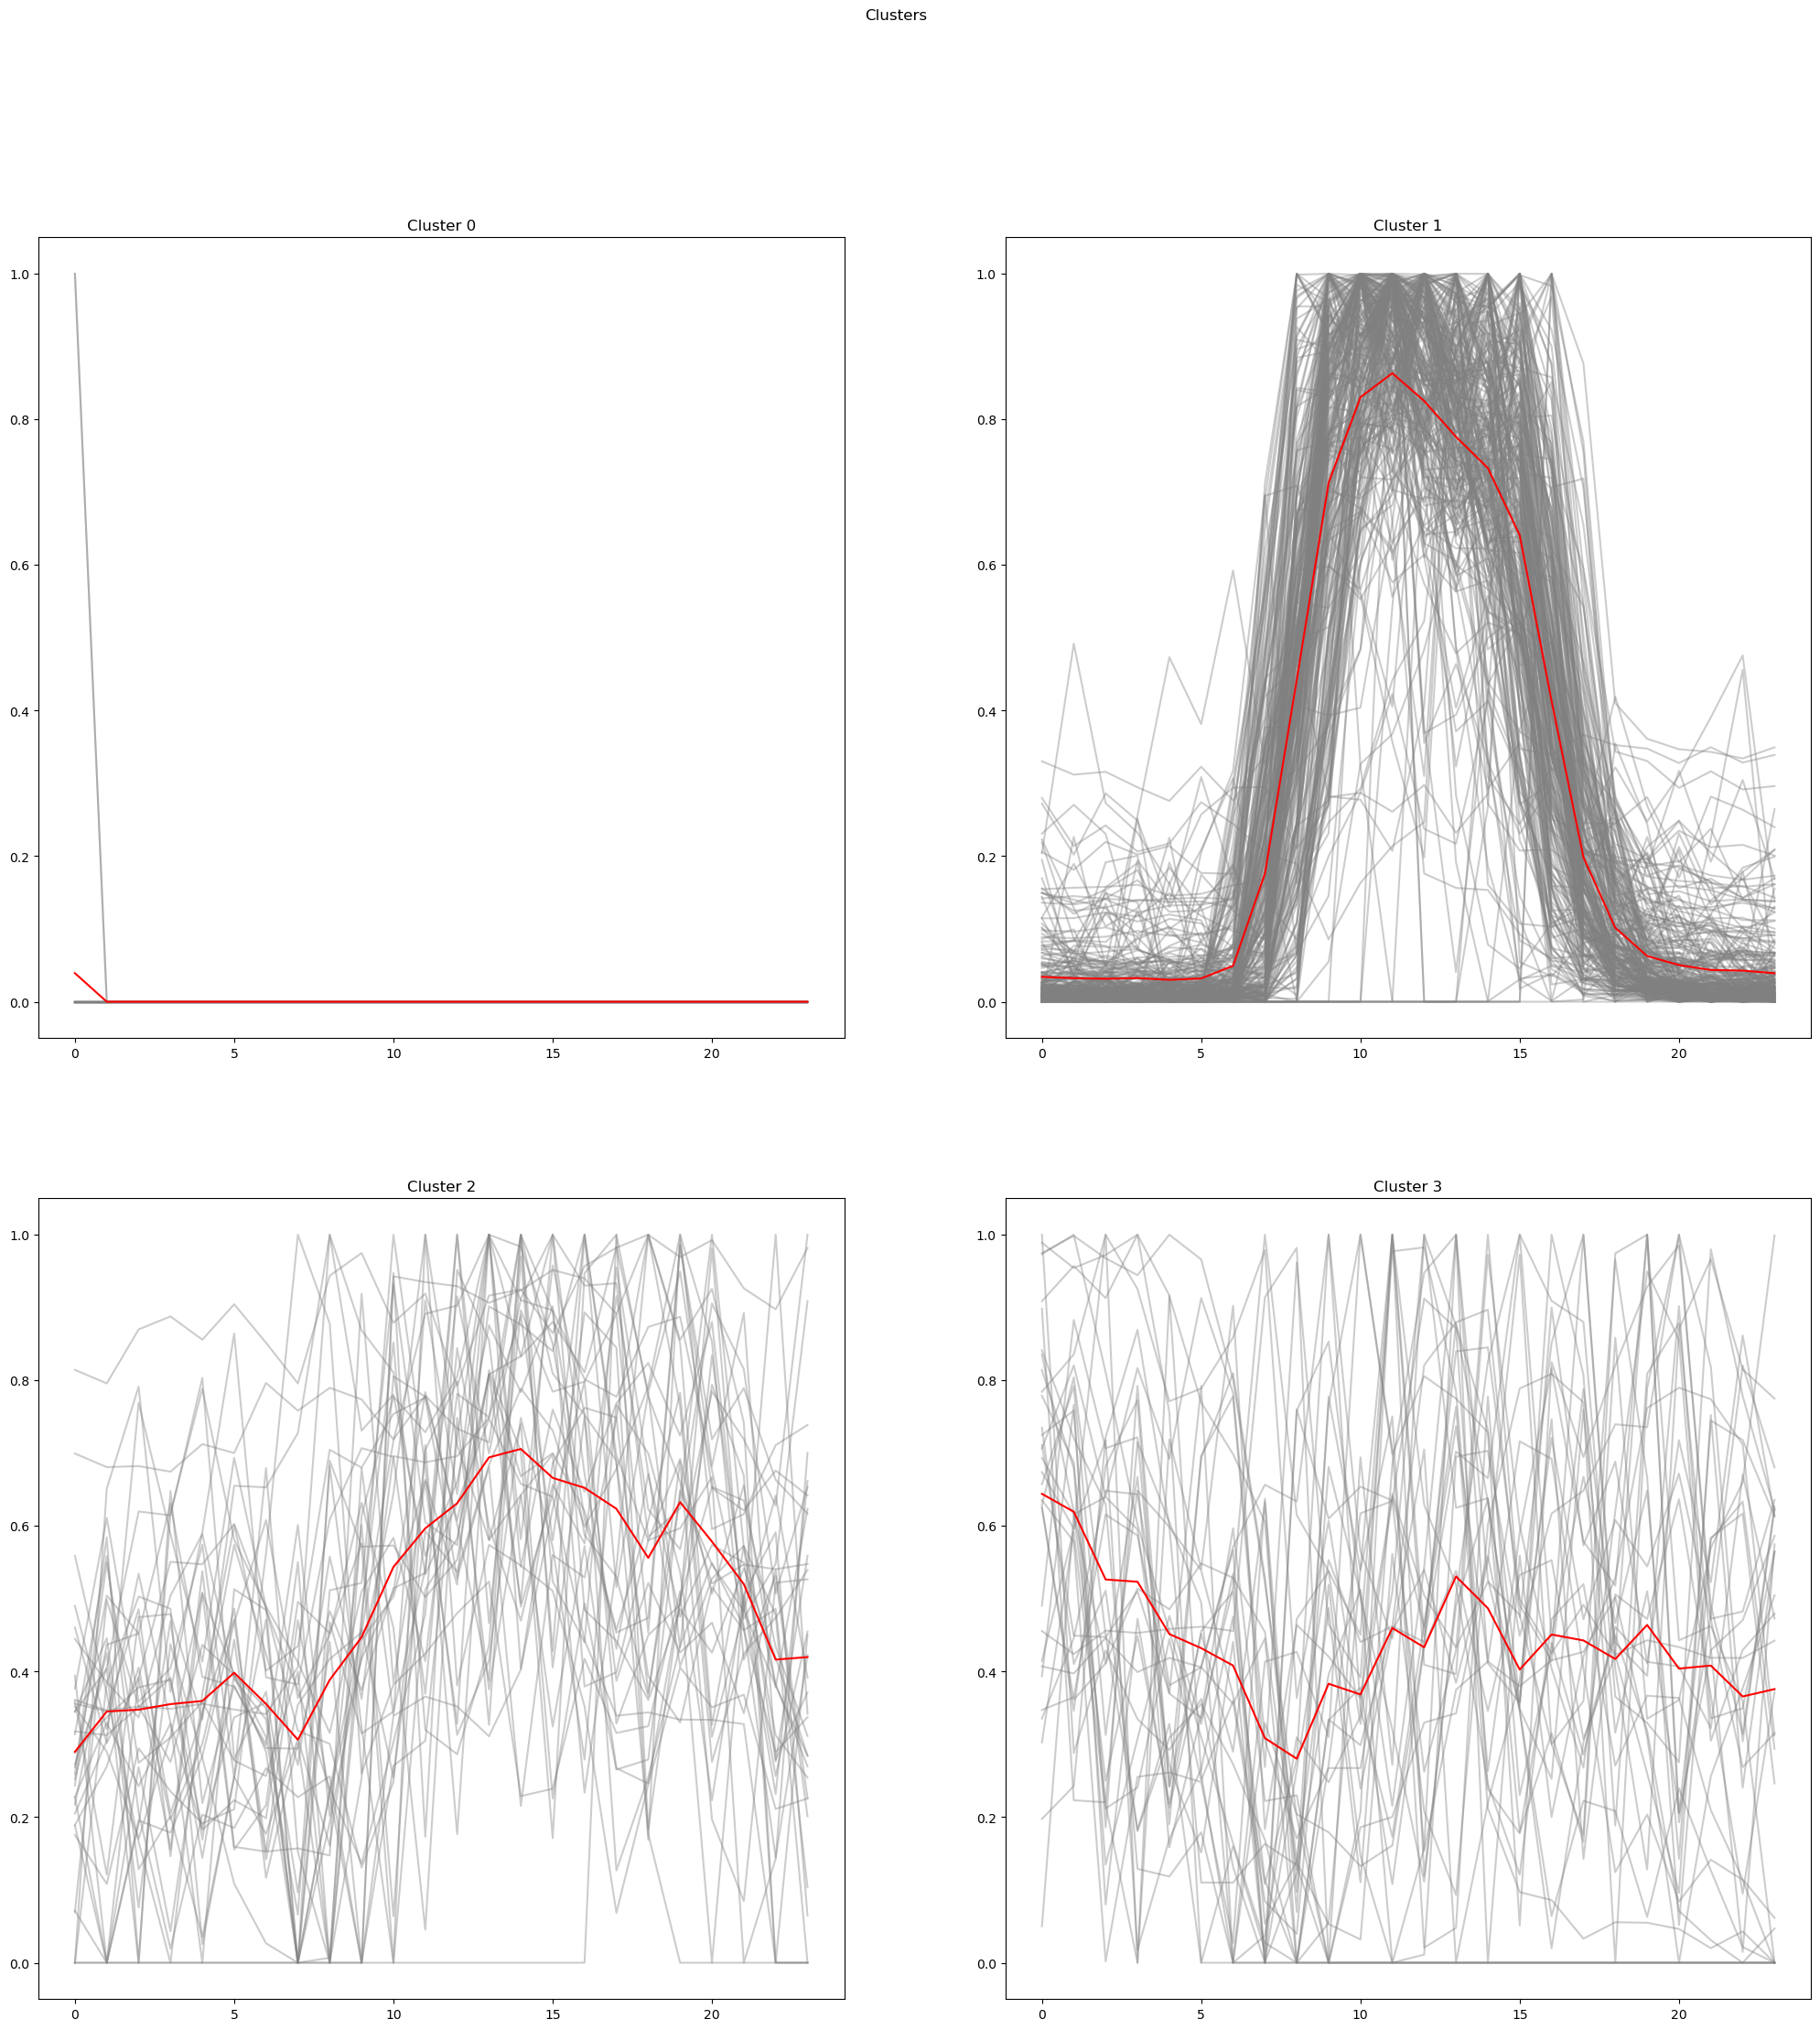

In [17]:
# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

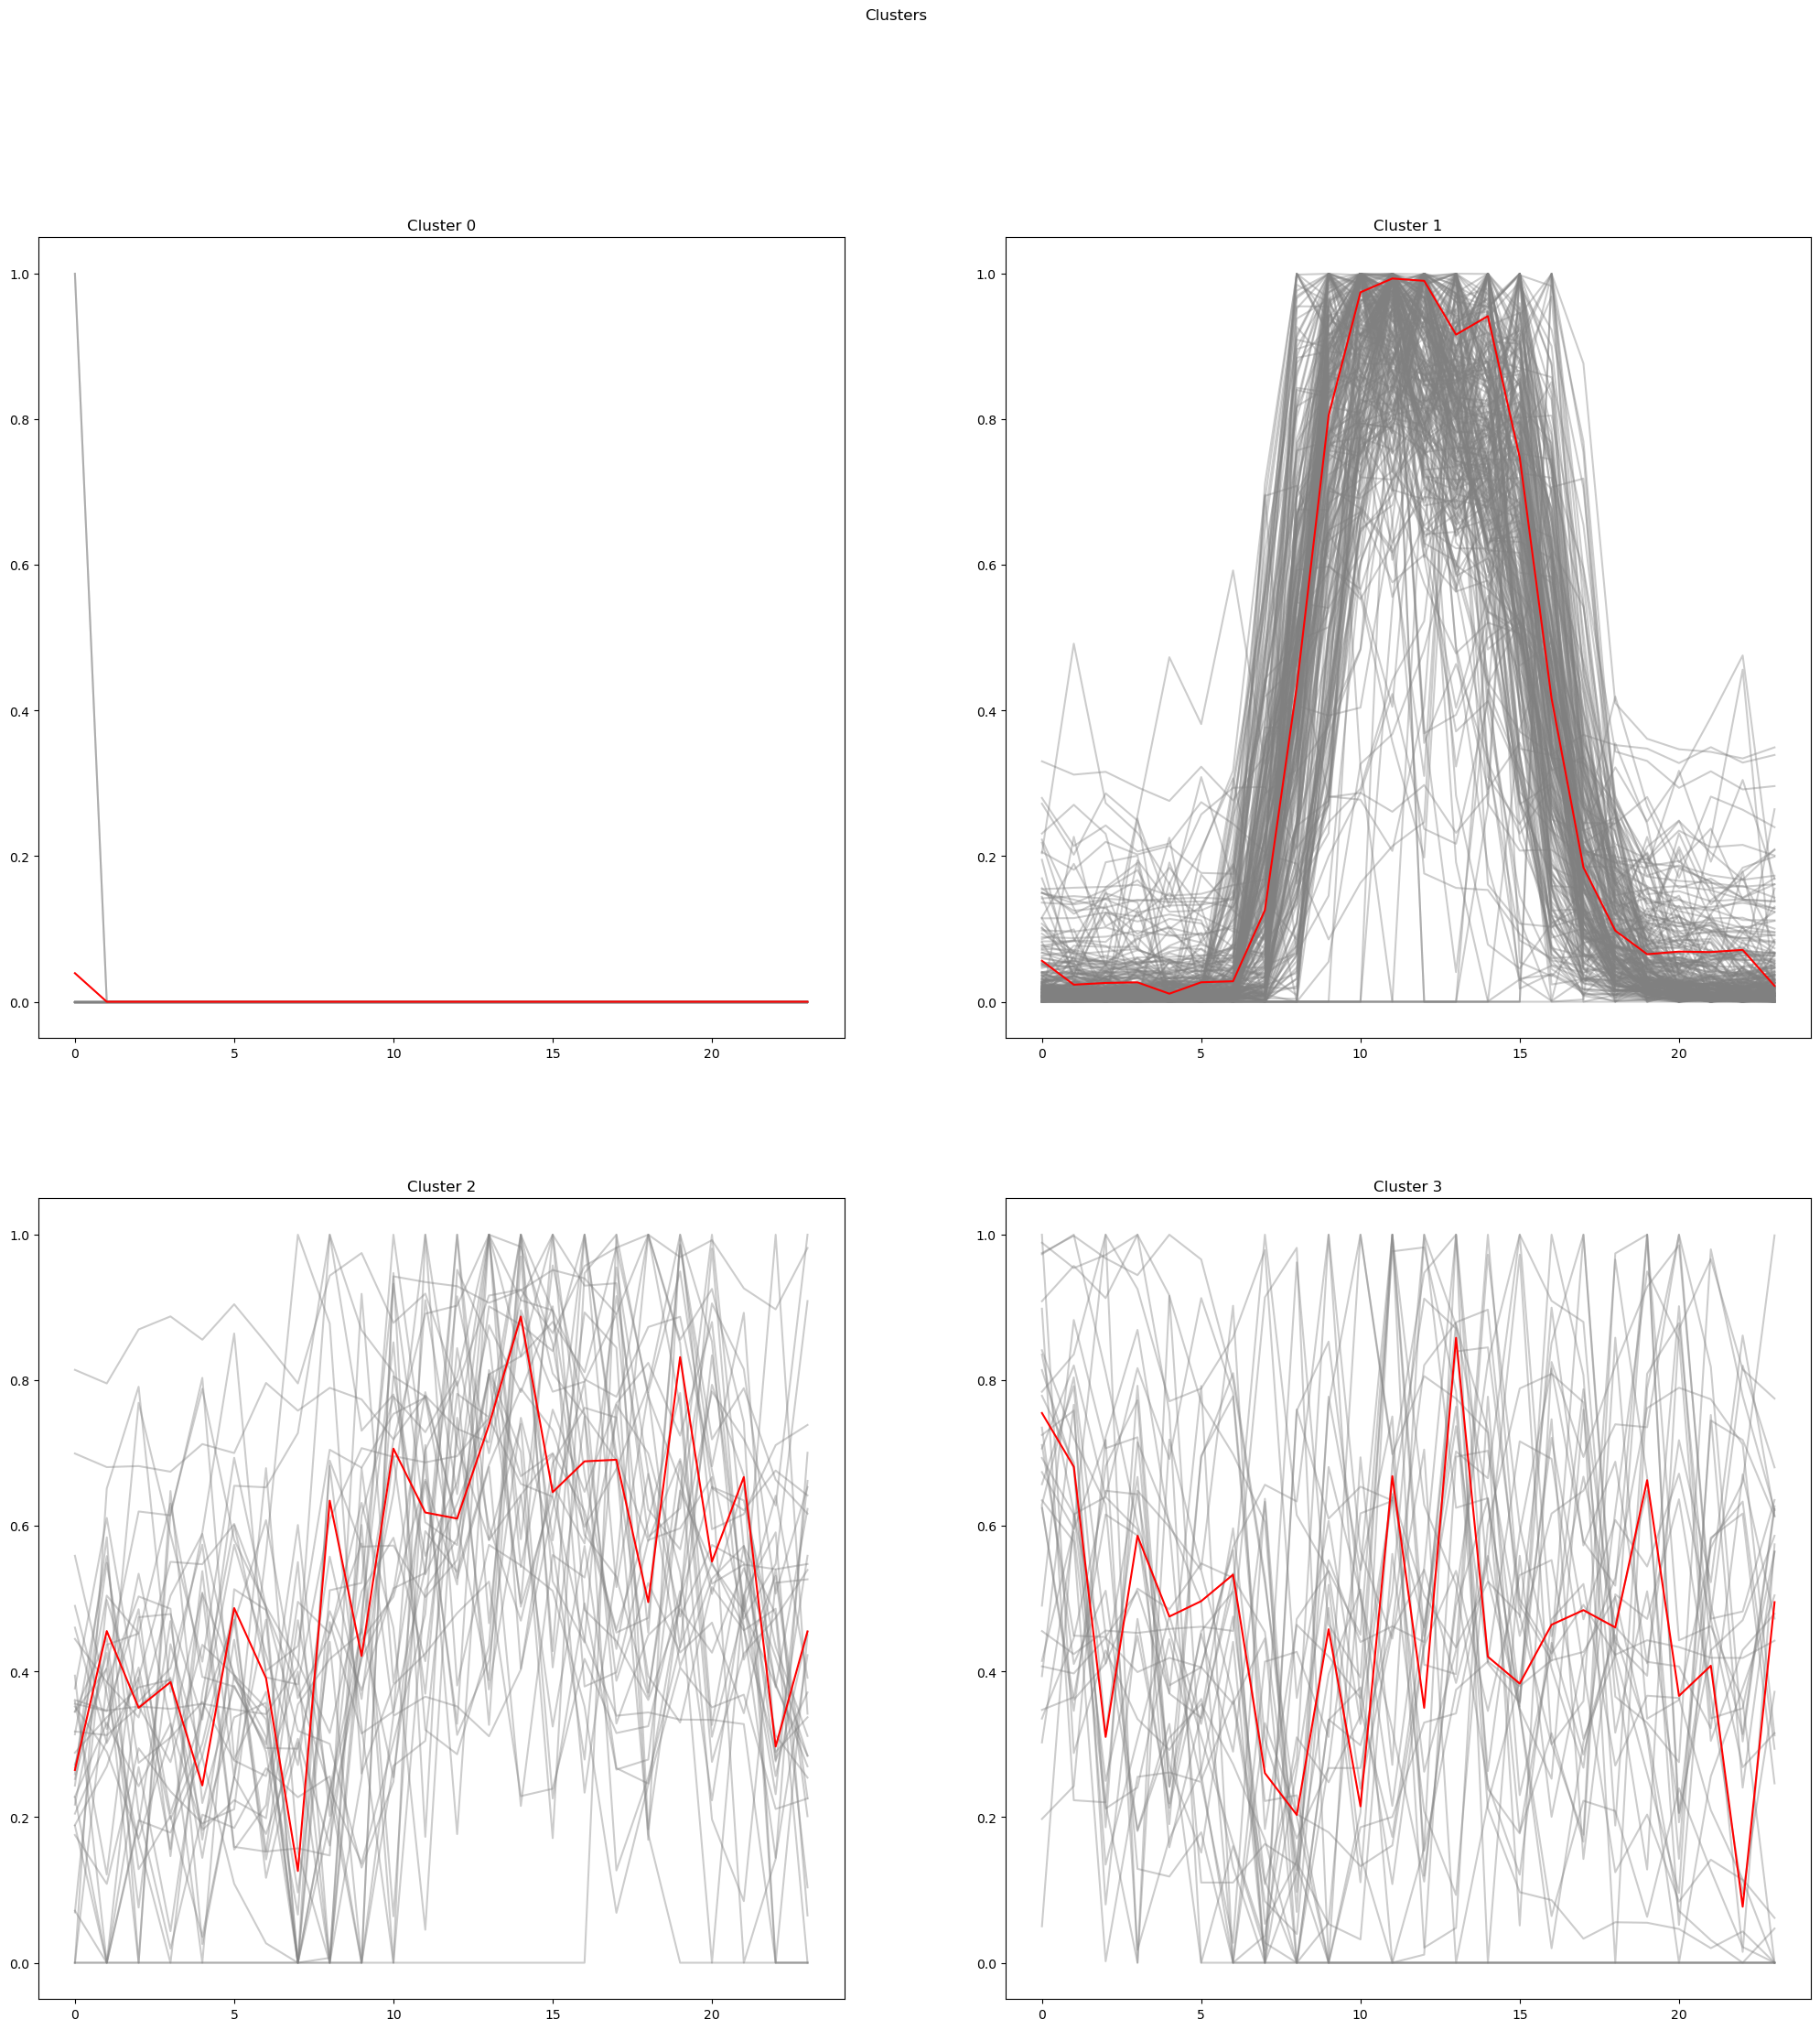

In [18]:
from tslearn.barycenters import dtw_barycenter_averaging

# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

Cantidad de series en cada cluster: [np.int64(51), np.int64(247), np.int64(35), np.int64(32)]


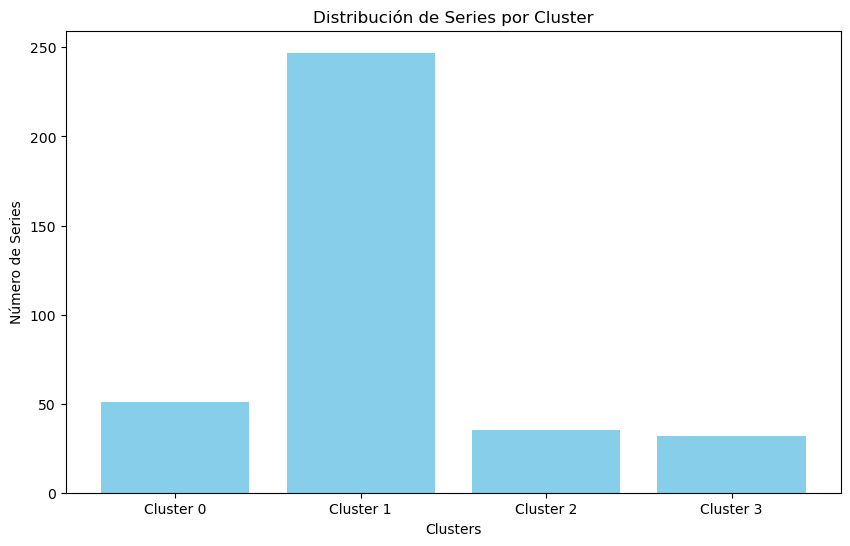

In [19]:
# Contar cuántas series pertenecen a cada cluster
cluster_counts = [np.sum(labels == i) for i in range(optimal_k)]

# Mostrar la cantidad de series en cada cluster
print("Cantidad de series en cada cluster:", cluster_counts)

# Etiquetas para los clusters
cluster_labels = [f"Cluster {i}" for i in range(optimal_k)]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(cluster_labels, cluster_counts, color='skyblue')
plt.title("Distribución de Series por Cluster")
plt.xlabel("Clusters")
plt.ylabel("Número de Series")
plt.show()


In [20]:
# Crear una lista vacía para almacenar las fechas y las etiquetas de los clusters
dates = []
cluster_labels = []

# Recorrer las series de tiempo, y asignar las fechas y las etiquetas correspondientes
for i, daily_df in enumerate(list_of_dataframes):
    current_dates = daily_df.index  # Obtener las fechas de este día
    dates.extend(current_dates)  # Añadir las fechas
    cluster_labels.extend([labels[i]] * len(current_dates))  # Añadir la etiqueta del cluster para cada fecha

# Crear un DataFrame con las fechas y las etiquetas de los clusters
df_clusters = pd.DataFrame({
    'Date': dates,
    'Cluster': cluster_labels
})

# Ver las primeras filas para verificar
df_clusters.head()


Date  Cluster
0 2023-01-01 00:00:00+00:00        2
1 2023-01-01 01:00:00+00:00        2
2 2023-01-01 02:00:00+00:00        2
3 2023-01-01 03:00:00+00:00        2
4 2023-01-01 04:00:00+00:00        2

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_12264\661334166.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)


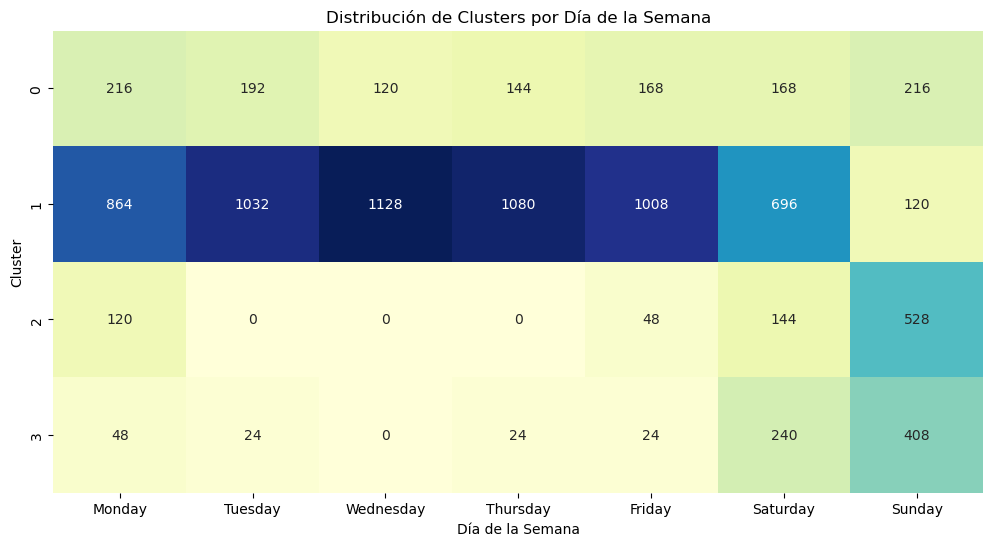

In [21]:
# Definir el orden correcto de los días de la semana
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)
df_clusters['Weekday'] = pd.to_datetime(df_clusters['Date']).dt.day_name()
# Convertir la columna 'Weekday' en una categoría ordenada
df_clusters['Weekday'] = df_clusters['Weekday'].astype(weekday_dtype)
df_clusters=df_clusters.sort_values(by="Weekday")
# Agrupar por cluster y día de la semana
weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)

import seaborn as sns

# Mostrar la distribución por día de la semana
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cluster')
plt.show()


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_12264\3457593411.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)


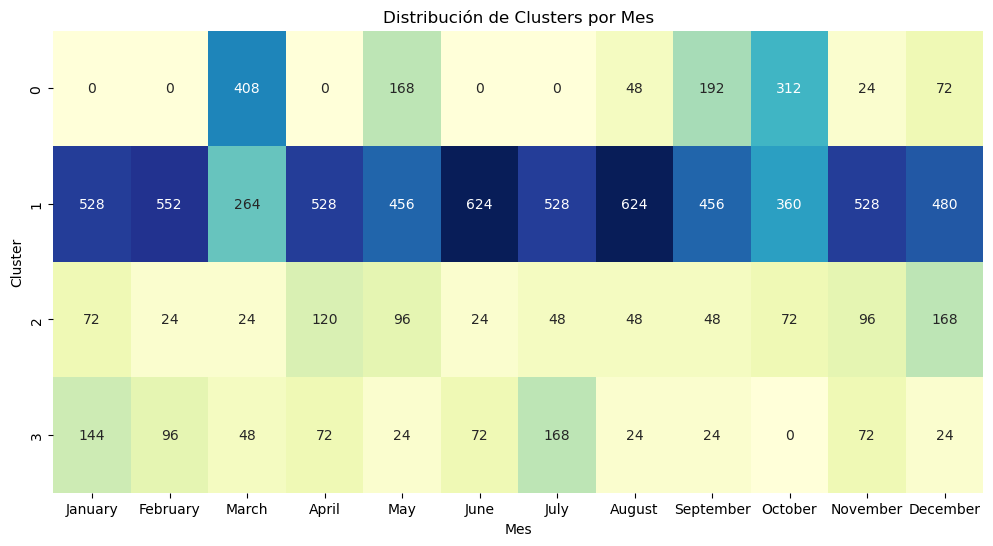

In [22]:
# Definir el orden correcto de los meses del año
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_dtype = pd.CategoricalDtype(categories=month_order, ordered=True)
df_clusters['Month'] = pd.to_datetime(df_clusters['Date']).dt.month_name()
# Convertir la columna 'Month' en una categoría ordenada
df_clusters['Month'] = df_clusters['Month'].astype(month_dtype)
df_clusters=df_clusters.sort_values(by="Month")

# Agrupar por cluster y mes
month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)

# Mostrar la distribución por mes
plt.figure(figsize=(12, 6))
sns.heatmap(month_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Mes')
plt.xlabel('Mes')
plt.ylabel('Cluster')
plt.show()


# Interpretación de los Clusters

Con base en los gráficos de la distribución por día de la semana y por mes, aquí está la interpretación de cada cluster:

## Cluster 0:

- **Día de la semana**: Este cluster tiene alta concentración durante los días de semana (especialmente lunes, martes, jueves y miércoles) con más de 1000 registros. Los domingos tienen una caída significativa (120 registros).
- **Mes**: Cluster 0 está presente a lo largo de todo el año, con alta concentración en agosto y junio (624 registros) y también en febrero y abril (552 y 528 registros, respectivamente). La distribución es bastante uniforme en comparación con otros clusters.
  
**Interpretación**: Cluster 0 parece representar patrones de consumo regulares durante días laborales, con menos actividad los domingos. Además, muestra un comportamiento continuo a lo largo del año, con algunos picos en meses de verano (junio, agosto) y finales de invierno (febrero).

---

## Cluster 1:

- **Día de la semana**: Este cluster tiene una presencia moderada los lunes, miércoles y domingos, con una menor concentración en otros días.
- **Mes**: Cluster 1 es dominante en marzo (384 registros) y en menor medida en octubre y mayo. Prácticamente desaparece durante meses como abril, enero, y junio.

**Interpretación**: Cluster 1 parece capturar patrones estacionales específicos, con una mayor concentración en marzo y octubre. Podría representar días con un comportamiento especial, como feriados o días de menor actividad.

---

## Cluster 2:

- **Día de la semana**: Alta concentración los sábados y domingos (especialmente los domingos con 840 registros), pero también con presencia moderada los lunes y viernes.
- **Mes**: Este cluster tiene mayor presencia en abril, enero y diciembre, aunque también aparece ligeramente en otros meses.

**Interpretación**: Cluster 2 captura días de fin de semana, especialmente domingos, donde el comportamiento del consumo es particular. A nivel mensual, muestra cierta estacionalidad en diciembre y enero, lo cual podría relacionarse con periodos festivos o de menor actividad.

---

## Cluster 3:

- **Día de la semana**: Este cluster tiene actividad muy baja. Aparece principalmente los sábados y domingos, con un pequeño número de registros (96 y 48 respectivamente).
- **Mes**: Cluster 3 aparece de forma esporádica en julio, agosto, y diciembre, con muy pocos registros.

**Interpretación**: Cluster 3 representa días con bajo consumo de energía, posiblemente periodos especiales como feriados prolongados o días atípicos. La presencia es mínima comparada con otros clusters.

---

## Resumen General:

- **Cluster 0**: Consumo regular en días laborales, presente durante todo el año.
- **Cluster 1**: Patrones específicos en marzo y octubre, concentrados en lunes, miércoles y domingos.
- **Cluster 2**: Días de fin de semana (sábados y domingos), con mayor presencia en diciembre y enero.
- **Cluster 3**: Días atípicos de bajo consumo, con actividad mínima.


Obtaining the original data with the cluster label

In [23]:
df_clusters =df_clusters.sort_values(by="Date").rename(columns={"Date": "timestamp"})
data_clustered=building_11a.reset_index()

In [24]:
data_clustered=data_clustered.merge(df_clusters[["timestamp", "Cluster"]],on="timestamp",how="left")

In [25]:
data_clustered

timestamp    kwh  Cluster
0    2023-01-01 00:00:00+00:00  54.90        2
1    2023-01-01 01:00:00+00:00  53.81        2
2    2023-01-01 02:00:00+00:00  52.92        2
3    2023-01-01 03:00:00+00:00  55.99        2
4    2023-01-01 04:00:00+00:00  57.55        2
...                        ...    ...      ...
8755 2023-12-31 19:00:00+00:00  70.52        2
8756 2023-12-31 20:00:00+00:00  72.07        2
8757 2023-12-31 21:00:00+00:00  72.65        2
8758 2023-12-31 22:00:00+00:00  71.43        2
8759 2023-12-31 23:00:00+00:00  65.27        2

[8760 rows x 3 columns]

## Forecasting

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [27]:
# Crear características temporales
def create_features(df):
    """
    Create time series features based on the 'timestamp' column.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.isocalendar().week
    return df

In [28]:
# Agregar lags a las series de tiempo
def add_lags(df):
    df = df.copy()
    df['lag1'] = df['kwh'].shift(24)  # Lag de 1 día (24 horas)
    df['lag2'] = df['kwh'].shift(48)  # Lag de 2 días
    df['lag3'] = df['kwh'].shift(72)  # Lag de 3 días
    return df

In [29]:
# Calcular sMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = numerator / denominator
    return ratio.mean()

In [30]:
# Separar datos en entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

In [31]:
train

timestamp    kwh  Cluster
0    2023-01-01 00:00:00+00:00  54.90        2
1    2023-01-01 01:00:00+00:00  53.81        2
2    2023-01-01 02:00:00+00:00  52.92        2
3    2023-01-01 03:00:00+00:00  55.99        2
4    2023-01-01 04:00:00+00:00  57.55        2
...                        ...    ...      ...
8563 2023-12-23 19:00:00+00:00  68.53        2
8564 2023-12-23 20:00:00+00:00  64.13        2
8565 2023-12-23 21:00:00+00:00  66.19        2
8566 2023-12-23 22:00:00+00:00  63.71        2
8567 2023-12-23 23:00:00+00:00  66.08        2

[8568 rows x 3 columns]

In [32]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

In [33]:
# Entrenamiento del modelo
def entrenamiento_modelo(cluster, data, data_cluster):
    # Filtrar las series del cluster actual
    cluster_data = data[data['Cluster'] == cluster].dropna()
    
    # Separar las características (X) y el target (y)
    X_train = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
    y_train = cluster_data['kwh']
    
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    cluster_data['predictions'] = y_train_pred
    predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    return model, predict_df

In [34]:
# Inferencia
def inference_models(cluster, data, models):
    cluster_data = data[data['Cluster'] == cluster].dropna()
    model = models.get(f"{cluster}")
    if not cluster_data.empty:
        X_infer = cluster_data.drop(columns=['timestamp', 'kwh', 'Cluster'])
        y_test_pred = model.predict(X_infer)
        cluster_data['predictions'] = y_test_pred
        predict_df = cluster_data.loc[:, ["timestamp", "kwh", "predictions"]]
    else:
        print(f"No hay datos en el testeo para el Cluster {cluster}")
        predict_df = pd.DataFrame()
    return predict_df


In [35]:
# Entrenamiento e inferencia por clusters
models = {}
train_results = pd.DataFrame()
test_results = pd.DataFrame()

for cluster in data_clustered['Cluster'].unique():
    print(f"\nEntrenando modelo para el Cluster {cluster}...")
    modelo, prediction_train = entrenamiento_modelo(cluster, train, data_clustered)
    models[f"{cluster}"] = modelo
    train_results = pd.concat([train_results, prediction_train], ignore_index=True)
    inference = inference_models(cluster, test, models)
    test_results = pd.concat([test_results, inference], ignore_index=True)

# Ordenar resultados
train_results = train_results.sort_values(by="timestamp")
test_results = test_results.sort_values(by="timestamp")



Entrenando modelo para el Cluster 2...

Entrenando modelo para el Cluster 3...
No hay datos en el testeo para el Cluster 3

Entrenando modelo para el Cluster 1...

Entrenando modelo para el Cluster 0...
No hay datos en el testeo para el Cluster 0


In [36]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 100.54639593095506
smape: 0.31345212628287433


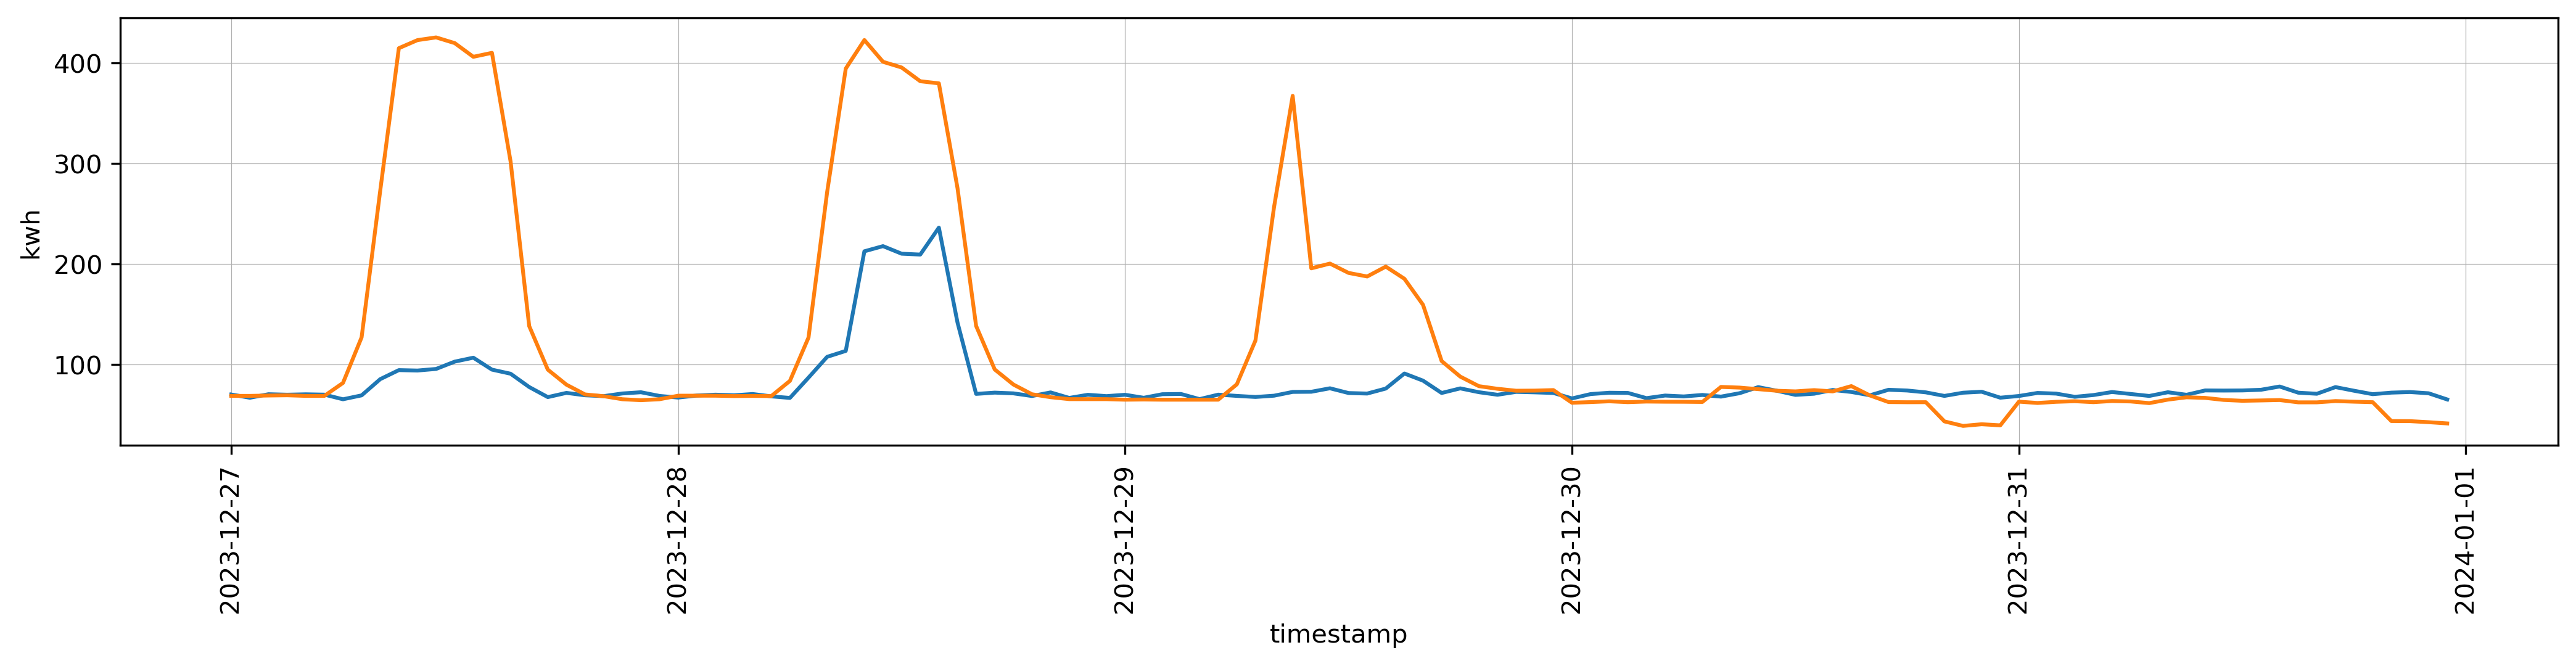

In [37]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Tunning models

In [38]:
models={}

## Tunning model cluster 0

In [39]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [40]:
# Filtrar datos por cluster
cluster = 0
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [41]:
cluster_data_train

timestamp    kwh  Cluster  hour  dayofweek  quarter  \
1608 2023-03-09 00:00:00+00:00  13.58        0     0          3        1   
1609 2023-03-09 01:00:00+00:00   0.00        0     1          3        1   
1610 2023-03-09 02:00:00+00:00   0.00        0     2          3        1   
1611 2023-03-09 03:00:00+00:00   0.00        0     3          3        1   
1612 2023-03-09 04:00:00+00:00   0.00        0     4          3        1   
...                        ...    ...      ...   ...        ...      ...   
8299 2023-12-12 19:00:00+00:00   0.00        0    19          1        4   
8300 2023-12-12 20:00:00+00:00   0.00        0    20          1        4   
8301 2023-12-12 21:00:00+00:00   0.00        0    21          1        4   
8302 2023-12-12 22:00:00+00:00   0.00        0    22          1        4   
8303 2023-12-12 23:00:00+00:00   0.00        0    23          1        4   

      month  dayofyear  dayofmonth  weekofyear   lag1   lag2   lag3  
1608      3         68           9          10  55.58  49.80  68.91  
1609      3         68           9          10  51.83  50.28  70.85  
1610      3         68           9          10  51.58  49.35  70.23  
1611      3         68           9          10  52.85  53.05  80.13  
1612      3         68           9          10  49.59  52.76  72.78  
...     ...        ...         ...         ...    ...    ...    ...  
8299     12        346          12          50   0.00   0.00  63.28  
8300     12        346          12          50   0.00   0.00  66.11  
8301     12        346          12          50   0.00   0.00  64.50  
8302     12        346          12          50   0.00   0.00  62.66  
8303     12        346          12          50   0.00   0.00  62.11  

[1224 rows x 13 columns]

In [42]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:0.52868	validation_1-mae:0.49545
[100]	validation_0-mae:0.20287	validation_1-mae:0.21507
[200]	validation_0-mae:0.07970	validation_1-mae:0.11912
[300]	validation_0-mae:0.03239	validation_1-mae:0.08819
[400]	validation_0-mae:0.01377	validation_1-mae:0.07945
[500]	validation_0-mae:0.00619	validation_1-mae:0.07785
[560]	validation_0-mae:0.00395	validation_1-mae:0.07799
[0]	validation_0-mae:0.51820	validation_1-mae:0.64996
[100]	validation_0-mae:0.19613	validation_1-mae:0.34118
[200]	validation_0-mae:0.07554	validation_1-mae:0.22745
[300]	validation_0-mae:0.02987	validation_1-mae:0.18563
[400]	validation_0-mae:0.01227	validation_1-mae:0.16996
[500]	validation_0-mae:0.00529	validation_1-mae:0.16416
[600]	validation_0-mae:0.00242	validation_1-mae:0.16202
[700]	validation_0-mae:0.00118	validation_1-mae:0.16125
[800]	validation_0-mae:0.00061	validation_1-mae:0.16097
[900]	validation_0-mae:0.00033	validation_1-mae:0.16087
[999]	validation_0-mae:0.00018	validation_1-mae:0.16

In [43]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [44]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación de validación (RMSE): 1.2362412986503135
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300        -1.236241   
1                 3                 0.01                 350        -1.274242   
2                 3                 0.01                 400        -1.303828   
3                 5                 0.01                 300        -1.236241   
4                 5                 0.01                 350        -1.274242   
5                 5                 0.01                 400        -1.303828   
6                 7                 0.01                 300        -1.236241   
7                 7                 0.01                 350        -1.274242   
8                 7                 0.01                 400        -1.303828   
9                 3                 0.0

In [45]:
# Entrenar el modelo
reg_0 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [46]:
reg_0.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
models["0"]=reg_0

## Tunning model cluster 1

In [48]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [49]:
# Filtrar datos por cluster
cluster = 1
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [50]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 2, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):

    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:165.43028	validation_1-mae:163.65308
[100]	validation_0-mae:68.14678	validation_1-mae:69.47181
[200]	validation_0-mae:46.66686	validation_1-mae:49.07601
[300]	validation_0-mae:42.30734	validation_1-mae:40.83611
[390]	validation_0-mae:40.77362	validation_1-mae:41.16089
[0]	validation_0-mae:165.35390	validation_1-mae:231.31872
[100]	validation_0-mae:68.06619	validation_1-mae:93.30975
[200]	validation_0-mae:46.67920	validation_1-mae:50.98457
[300]	validation_0-mae:42.35127	validation_1-mae:41.43259
[400]	validation_0-mae:40.64426	validation_1-mae:41.06880
[401]	validation_0-mae:40.61953	validation_1-mae:41.08056
[0]	validation_0-mae:165.94294	validation_1-mae:218.99254
[100]	validation_0-mae:68.27130	validation_1-mae:82.76234
[200]	validation_0-mae:46.74849	validation_1-mae:49.82222
[300]	validation_0-mae:42.28029	validation_1-mae:42.56715
[400]	validation_0-mae:40.61666	validation_1-mae:41.00469
[459]	validation_0-mae:39.92793	validation_1-mae:41.09073


In [51]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [52]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Mejor puntuación de validación (RMSE): 86.6202669508957
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 100      -103.513068   
1                 3                 0.01                 200       -92.114823   
2                 3                 0.01                 300       -86.681296   
3                 5                 0.01                 100      -102.222872   
4                 5                 0.01                 200       -88.423724   
5                 5                 0.01                 300       -87.885889   
6                 7                 0.01                 100      -105.629045   
7                 7                 0.01                 200       -92.159128   
8                 7                 0.01                 300       -90.638753   
9                 3                 0.05 

In [53]:
# Entrenar el modelo
reg_1 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=100,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [54]:
reg_1.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
models["1"]=reg_1

## Tunning model cluster 2

In [56]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [57]:
# Filtrar datos por cluster
cluster = 2
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [58]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 5, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:49.10526	validation_1-mae:51.18675
[100]	validation_0-mae:18.88436	validation_1-mae:25.40067
[200]	validation_0-mae:7.42480	validation_1-mae:17.46910
[300]	validation_0-mae:3.47290	validation_1-mae:14.27124
[400]	validation_0-mae:2.25946	validation_1-mae:13.39329
[500]	validation_0-mae:1.78596	validation_1-mae:13.25917
[600]	validation_0-mae:1.57795	validation_1-mae:13.24478
[700]	validation_0-mae:1.38833	validation_1-mae:13.16368
[800]	validation_0-mae:1.24909	validation_1-mae:13.12251
[856]	validation_0-mae:1.17384	validation_1-mae:13.12518
[0]	validation_0-mae:49.61175	validation_1-mae:49.96020
[100]	validation_0-mae:18.81329	validation_1-mae:25.16755
[200]	validation_0-mae:7.46992	validation_1-mae:16.36761
[300]	validation_0-mae:3.69743	validation_1-mae:13.56185
[400]	validation_0-mae:2.58158	validation_1-mae:12.43834
[500]	validation_0-mae:2.19481	validation_1-mae:12.09801
[600]	validation_0-mae:1.99892	validation_1-mae:11.99064
[700]	validation_0-mae:1.85714	

In [59]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [60]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [800, 900, 950],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 800}
Mejor puntuación de validación (RMSE): 17.340667700192203
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 800       -17.340668   
1                 3                 0.01                 900       -17.436298   
2                 3                 0.01                 950       -17.464321   
3                 5                 0.01                 800       -18.841750   
4                 5                 0.01                 900       -18.844482   
5                 5                 0.01                 950       -18.851683   
6                 7                 0.01                 800       -19.238604   
7                 7                 0.01                 900       -19.240115   
8                 7                 0.01                 950       -19.237710   
9                 3                 0.0

In [61]:
# Entrenar el modelo
reg_2 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=800,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [62]:
reg_2.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
models["2"]=reg_2

## Tunning model cluster 3

In [64]:
# Separar en conjuntos de entrenamiento y prueba
train = data_clustered.loc[data_clustered['timestamp'] < '2023-12-24']
test = data_clustered.loc[data_clustered['timestamp'] >= '2023-12-24']

# Crear características y agregar lags
train = create_features(train)
train = add_lags(train)
test = create_features(test)
test = add_lags(test)

In [65]:
# Filtrar datos por cluster
cluster = 3
cluster_data_train = train[train['Cluster'] == cluster].dropna()

In [67]:
from sklearn.model_selection import TimeSeriesSplit
# Configuración de TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 7, gap=12)

# Preparar los datos para los folds
df = cluster_data_train.sort_values(by='timestamp')
fold = 0
preds = []
scores = []
scores_smape = []

# Validación cruzada con TimeSeriesSplit
for train_idx, val_idx in tss.split(df):
    train_split = df.iloc[train_idx]
    test_split = df.iloc[val_idx]

    TARGET = 'kwh'
    X_train = train_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_train = train_split[TARGET]

    X_test = test_split.drop(columns=['timestamp', TARGET, 'Cluster'])
    y_test = test_split[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        eval_metric='mae'
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)

[0]	validation_0-mae:52.91527	validation_1-mae:41.90487
[100]	validation_0-mae:19.67257	validation_1-mae:19.75284
[191]	validation_0-mae:8.03162	validation_1-mae:19.06144
[0]	validation_0-mae:48.75870	validation_1-mae:55.26456
[100]	validation_0-mae:18.21216	validation_1-mae:24.50891
[200]	validation_0-mae:6.99663	validation_1-mae:13.01936
[300]	validation_0-mae:3.50641	validation_1-mae:10.07850
[400]	validation_0-mae:2.71937	validation_1-mae:9.55670
[500]	validation_0-mae:2.49474	validation_1-mae:9.42404
[600]	validation_0-mae:2.33351	validation_1-mae:9.36528
[604]	validation_0-mae:2.32994	validation_1-mae:9.36653
[0]	validation_0-mae:50.79192	validation_1-mae:53.11968
[100]	validation_0-mae:19.72680	validation_1-mae:35.51465
[200]	validation_0-mae:8.12039	validation_1-mae:29.29881
[300]	validation_0-mae:5.11712	validation_1-mae:26.92933
[400]	validation_0-mae:4.16755	validation_1-mae:26.11494
[500]	validation_0-mae:3.75611	validation_1-mae:26.09062
[529]	validation_0-mae:3.67075	vali

In [68]:
# Optimización de hiperparámetros con GridSearchCV
X_train = cluster_data_train.drop(columns=['timestamp', 'kwh', 'Cluster'])
y_train = cluster_data_train['kwh']

In [69]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE como métrica
    cv=3
)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, multiplicado por -1 para interpretarlo)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación de validación (RMSE): 20.825888581298685
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -20.825889   
1                 3                 0.01                 350       -21.013400   
2                 3                 0.01                 400       -21.185510   
3                 5                 0.01                 300       -25.589293   
4                 5                 0.01                 350       -25.659855   
5                 5                 0.01                 400       -25.688942   
6                 7                 0.01                 300       -26.401821   
7                 7                 0.01                 350       -26.407763   
8                 7                 0.01                 400       -26.401894   
9                 3                 0.0

In [70]:
# Entrenar el modelo
reg_3 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=300,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [71]:
reg_3.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
models["3"]=reg_3

## Final analysis

In [88]:
len(models)

4

In [93]:
import time
start_time = time.time()
# Inicializar DataFrames para resultados
train_results = pd.DataFrame()
test_results = pd.DataFrame()

# Inferencia por cluster usando data_clustered
for cluster in data_clustered['Cluster'].unique():
    print(f"\nInferencia modelo para el Cluster {cluster}...")
    # Filtrar el subconjunto de test para el cluster actual
    test_cluster = test[test['Cluster'] == cluster]
    if not test_cluster.empty:
        inference = inference_models(cluster, test_cluster, models)
        test_results = pd.concat([test_results, inference], ignore_index=True)
    else:
        print(f"No hay datos de test para el Cluster {cluster}.")

# Calcular el tiempo de ejecución
execution_time = time.time() - start_time

# Imprimir el tiempo de ejecución
print(f"Tiempo de ejecución: {execution_time} segundos")


Inferencia modelo para el Cluster 2...

Inferencia modelo para el Cluster 3...
No hay datos de test para el Cluster 3.

Inferencia modelo para el Cluster 1...

Inferencia modelo para el Cluster 0...
No hay datos de test para el Cluster 0.
Tiempo de ejecución: 0.0076100826263427734 segundos


In [94]:
# Ordenar resultados por timestamp
test_results = test_results.sort_values(by="timestamp")

# Calcular métricas de evaluación
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))
smape_score = smape(test_results["kwh"], test_results["predictions"])

# Mostrar resultados finales
print("\nResultados:")
print("RMSE:", mse)
print("SMAPE:", smape_score)


Resultados:
RMSE: 38.27120030033417
SMAPE: 0.279743780333798


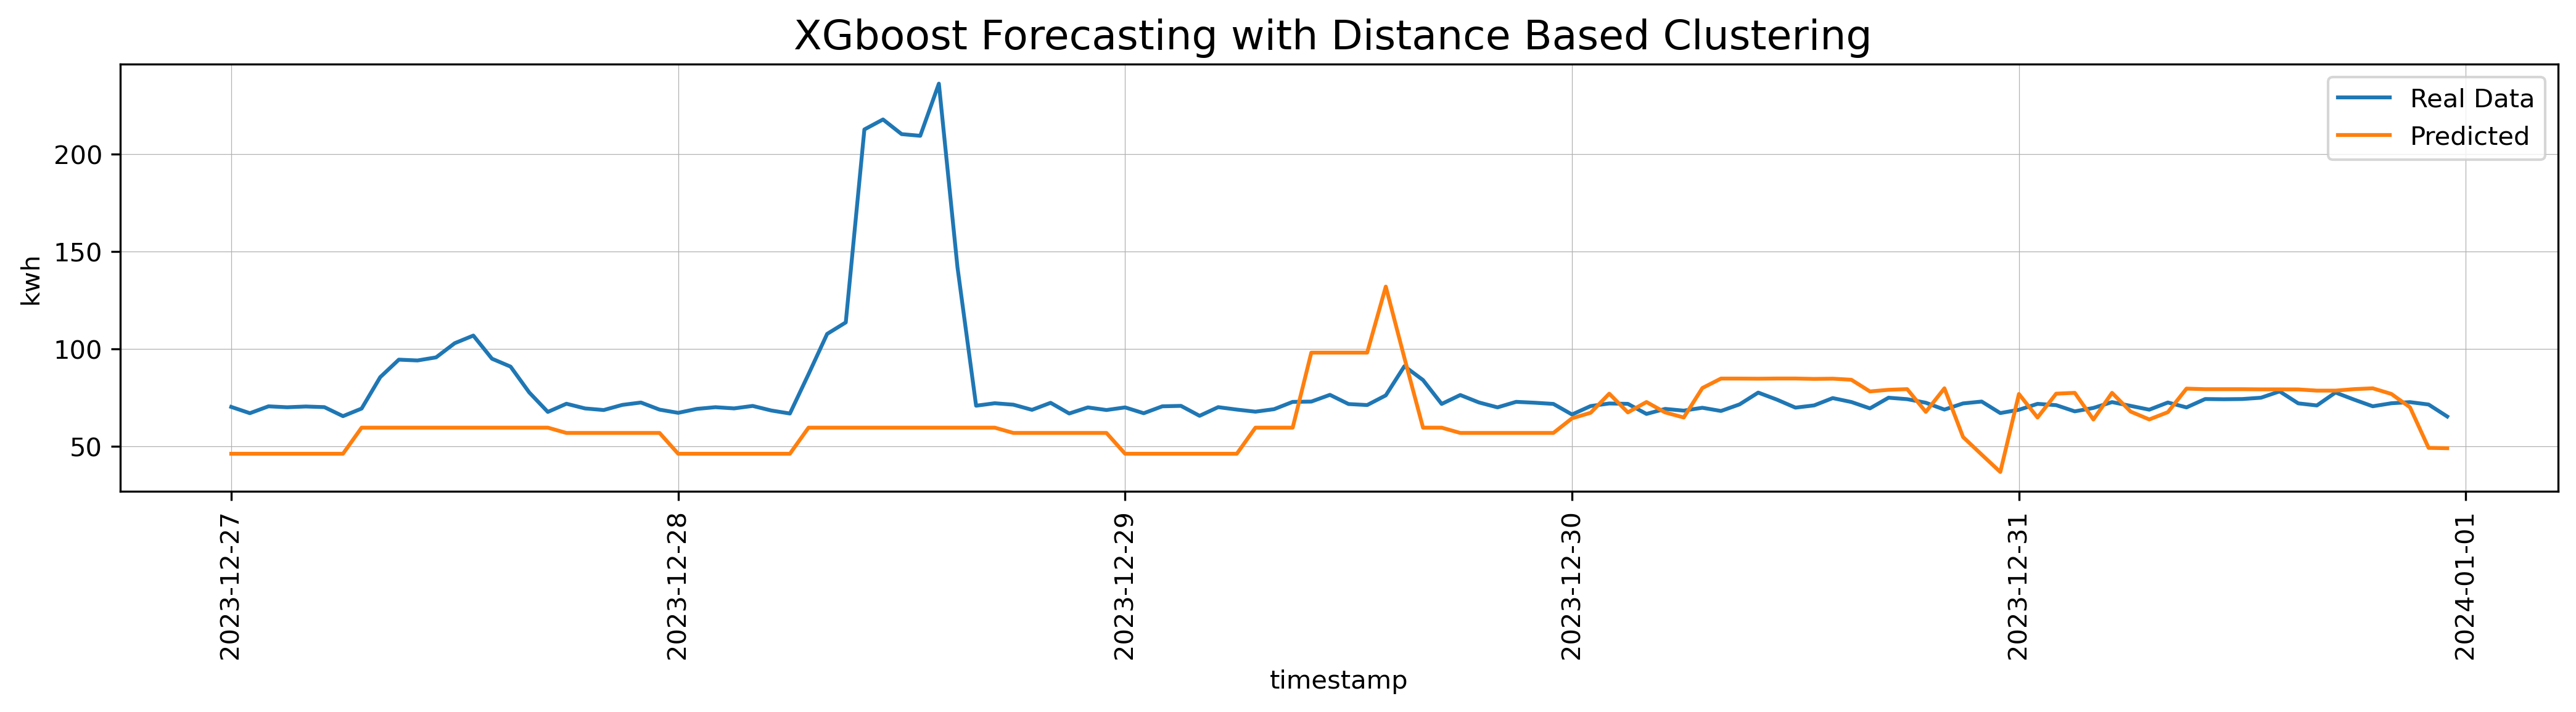

In [76]:
# Visualización
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh', label='Real Data')
sns.lineplot(data=test_results, x='timestamp', y='predictions', label='Predicted')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.title('XGboost Forecasting with Distance Based Clustering ', fontsize=16)
plt.legend()
plt.show()